In [1]:
import os
from config import LR, NUM_EPOCHS, RANDOM_STATE, TEST_PATH, TRAIN_PATH
from data_and_preprocessors.data import load_data
from data_and_preprocessors.preprocessors import build_transformer_for_tree, build_transformer_for_regression

from classic_ml.evaluate_pipes import evaluate_pipes
from classic_ml.pipeline import make_pipelines
from classic_ml.grid_search import grid_search
from classic_ml.staking import build_and_fit_stacking

from mlp.mlp_model import MLPClassifier
from mlp.train_mlp import train_all_mlps
from mlp.mlp_prepare_data import mlp_prepare_data
from mlp.mlp_pipeline import make_mlp_pipeline
from mlp.plot_mlp_training_loss import plot_mlp_training_loss
from mlp.evaluate_mlp import evaluate_mlps, evaluate_mlp

from sklearn.model_selection import train_test_split



PYTHONPATH: ./src


In [2]:
test_data, train_data, target_data, idx = load_data(TRAIN_PATH, TEST_PATH)

categorical_cols = test_data.select_dtypes(include=['object']).columns
numerical_cols = test_data.select_dtypes(exclude=['object']).columns.drop(['person_age', 'person_income'])

X_train, X_test, y_train, y_test = train_test_split(train_data, target_data, test_size=0.2, 
                                        random_state=RANDOM_STATE, stratify=target_data)

In [ ]:
pipelines = make_pipelines(numerical_cols.tolist(), categorical_cols.tolist(), random_state=RANDOM_STATE)
best_models = grid_search(pipelines, X_train, y_train, random_state=RANDOM_STATE)
stack = build_and_fit_stacking(best_models['rf'], best_models['lgbm'], X_train, y_train, random_state=RANDOM_STATE)

print("\nClassic ML models evaluation:")
evaluate_pipes(best_models, X_test, y_test,)
print("\nStacking evaluation:")
evaluate_pipes({'stacking': stack}, X_test, y_test)

RF best: {'clf__max_depth': 20, 'clf__min_samples_split': 2, 'clf__n_estimators': 200}
LR best: {'clf__C': 1, 'clf__penalty': 'l2', 'clf__solver': 'liblinear'}
Fitting 5 folds for each of 12 candidates, totalling 60 fits


d:\py\Lib\site-packages\sklearn\model_selection\_search.py:317: UserWarning: The total space of parameters 12 is smaller than n_iter=20. Running 12 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


[LightGBM] [Info] Number of positive: 6490, number of negative: 40122
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001508 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 850
[LightGBM] [Info] Number of data points in the train set: 46612, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Info] Start training from score 0.000000
LGBM best: {'clf__num_leaves': 31, 'clf__n_estimators': 100, 'clf__learning_rate': 0.1}

Classic ML models evaluation:
--- rf ---
balanced_accuracy: 0.845641172600498
f1_macro: 0.8843734626277383
roc_auc_macro: 0.9341302033517439

--- lr ---
balanced_accuracy: 0.8360550511128353
f1_macro: 0.7487118785947287
roc_auc_macro: 0.9047919396462493

--- lgbm ---
balanced_accuracy: 0.8878744849861997
f1_macro: 0.8508949269908175
roc_auc_macro: 0.95677

d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


--- stacking ---
balanced_accuracy: 0.8870209765036375
f1_macro: 0.839344646911675
roc_auc_macro: 0.9567293805582635



d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(


In [4]:
train_loader, test_loader, weight, input_dim = mlp_prepare_data(X_train, X_test, y_train, y_test, numerical_cols, categorical_cols)
mlp_pipe = make_mlp_pipeline(input_dim)

Training model: large
Epoch [5/50], Loss: 0.6695
Epoch [10/50], Loss: 0.6502
Epoch [15/50], Loss: 0.6342
Epoch [20/50], Loss: 0.6398
Epoch [25/50], Loss: 0.6314
Epoch [30/50], Loss: 0.6331
Epoch [35/50], Loss: 0.6269
Epoch [40/50], Loss: 0.6317
Epoch [45/50], Loss: 0.6314
Epoch [50/50], Loss: 0.6303
Training model: medium
Epoch [5/50], Loss: 0.7079
Epoch [10/50], Loss: 0.6946
Epoch [15/50], Loss: 0.6854
Epoch [20/50], Loss: 0.6785
Epoch [25/50], Loss: 0.6778
Epoch [30/50], Loss: 0.6711
Epoch [35/50], Loss: 0.6762
Epoch [40/50], Loss: 0.6750
Epoch [45/50], Loss: 0.6690
Epoch [50/50], Loss: 0.6775
Training model: small
Epoch [5/50], Loss: 0.7843
Epoch [10/50], Loss: 0.7591
Epoch [15/50], Loss: 0.7546
Epoch [20/50], Loss: 0.7514
Epoch [25/50], Loss: 0.7582
Epoch [30/50], Loss: 0.7424
Epoch [35/50], Loss: 0.7582
Epoch [40/50], Loss: 0.7404
Epoch [45/50], Loss: 0.7415
Epoch [50/50], Loss: 0.7496
Training model: deep
Epoch [5/50], Loss: 1.0324
Epoch [10/50], Loss: 1.0224
Epoch [15/50], Loss:

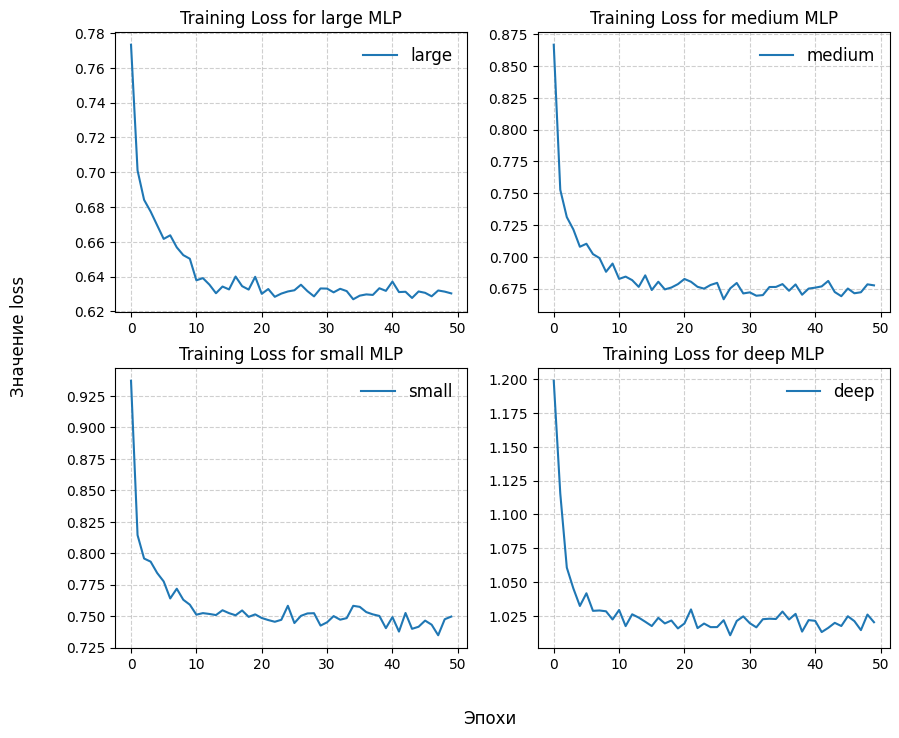

In [5]:
train_loss = train_all_mlps(mlp_pipe, train_loader, weight, n_epochs=NUM_EPOCHS, lr=LR)
plot_mlp_training_loss(mlp_pipe, test_loader)

In [ ]:
for model_name, model in mlp_pipe.items():
    evaluate_mlp(model, test_loader, threshold=0.7)


balanced_accuracy: 0.8472
f1_macro: 0.8539
roc_auc: 0.9286120381922623

balanced_accuracy: 0.8445
f1_macro: 0.8548
roc_auc: 0.9285840261102092

balanced_accuracy: 0.8423
f1_macro: 0.8458
roc_auc: 0.9262058249158869

balanced_accuracy: 0.7614
f1_macro: 0.814
roc_auc: 0.9251470480732786



In [35]:
import pandas as pd
ans = pd.DataFrame({'id': idx})
ans['loan_status'] = best_models['lgbm'].predict_proba(test_data)[:, 1]
ans.to_csv('submission.csv', index=False)

d:\py\Lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but LGBMClassifier was fitted with feature names
  warnings.warn(
